In [20]:
#Import libraries

import numpy as np
import os
import matplotlib.pyplot as plt
import pickle

from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l2
from keras.utils import to_categorical
from keras.utils import multi_gpu_model
from keras.utils import Sequence
from keras.models import load_model
from tensorflow.distribute import MirroredStrategy

In [21]:
#Define Data gemerator

rng = np.random.default_rng()
class FelixSequence(Sequence):
    def __init__(self, x_set, y_set, batch_size, file_type):
        """Here self.x is a list of paths to file_type files. self.y is a
        corresponding list of labels."""
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.file_type = file_type

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return arrs_from_paths(batch_x, self.file_type), to_categorical(np.array(batch_y),10)

def gen_paths_labels(base_path = "D:\\Uni Work\\Masters Project\\test_dir"):
    """A generator to yield (data-paths, corresponding labels) tuples for each
    segment of data (typically training, validation, and testing)."""
    for segment in sorted(os.listdir(base_path)):
        segment_path = os.path.join(base_path, segment)
        segment_paths = []
        segment_labels = []
        for label in os.listdir(segment_path):
            label_path = os.path.join(segment_path, label)
            for crystal in os.listdir(label_path):
                segment_paths.append(os.path.join(label_path, crystal))
                segment_labels.append(label)
        indexes = np.arange(len(segment_labels))
        rng.shuffle(indexes)
        yield [np.array(segment_paths)[indexes], np.array(list(map(int,segment_labels)))[indexes]]

def arrs_from_paths(paths, file_type):
    if file_type == "txt":
        return np.array([np.loadtxt(file_name) for file_name in paths])
    elif file_type == "npy":
        return np.array([np.load(file_name) for file_name in paths])

In [22]:
#All paths

Path = "/home/ug-ml/felix-ML/DataGenerator2/Data" #Path where training and validation data is
SaveDataPath = "/home/ug-ml/Documents/GitHub_BigFiles/SaveFolder" #Base directory of place you store information of models
SaveFolderName = "/Convnet3" #Will create a folder and put in information about the outcome / inputs
ModelName = "/Convnet3.hdf5"


#Many variables

#Model Variables
input_shape = (36, 128, 128)

#Hyper parameters
learning_rate = 0.0005
l2_regularizer = 0.0001
loss = 'categorical_crossentropy'
optimizer = "RMSprop" #Not a variable ONLY used for a note
batch_size = 32
epochs = 100
ShuffleTrainData = True

#Call back variables
TrainingPatience = 20
CheckPointMonitor = 'val_acc'
EarlyStopMonitor = 'val_loss'

#CPU variables
CPUworkers = 16


#List the name of the variables you want to save in a file
VariableListName = ["input_shape", 
                   "learning_rate", "l2_regularizer", "loss", "optimizer", "batch_size", "epochs", "ShuffleTrainData",
                   "TrainingPatience", "CheckPointMonitor", "EarlyStopMonitor",
                   "CPUworkers"]

#List the variables in the same order as VariableListName
VariableListValues = [input_shape, 
                   learning_rate, l2_regularizer, loss, optimizer, batch_size, epochs, ShuffleTrainData,
                   TrainingPatience, CheckPointMonitor, EarlyStopMonitor,
                   CPUworkers]




In [23]:
#Early stopping and check points

EarlyStop = EarlyStopping(monitor = EarlyStopMonitor,
                          mode = 'min',
                          verbose = 1,
                          patience = TrainingPatience)

NewPath = SaveDataPath + SaveFolderName
Checkpoint = ModelCheckpoint(NewPath + ModelName, #Save path
                             monitor = CheckPointMonitor,
                             verbose = 1,
                             save_best_only = True,
                             mode = 'auto',
                             save_freq = 'epoch')


#Make folder to put model and history information
try:
    os.mkdir(NewPath)
except:
    print("Folder failed to be created, it may already exist")
    
File1  = open(NewPath +"/Parameters.txt", "w+")
if(len(VariableListName) == len(VariableListValues)):
    for i in range(0, len(VariableListName)):
        File1.write(VariableListName[i] + " " + str(VariableListValues[i]) + "\n")
else:
    print("VariableListName and VariableListValues do not match up, so file can not be saved")


Folder failed to be created, it may already exist


In [24]:
#Build model
strategy = MirroredStrategy() #Allows multiple GPUs

with strategy.scope():
    model = models.Sequential()
    model.add(layers.SeparableConv2D(128, (3, 3),
                                     activation='relu',
                                     data_format='channels_first',
                                     input_shape= input_shape))
    model.add(layers.MaxPooling2D((2, 2), data_format='channels_first'))
    model.add(layers.SeparableConv2D(128, (3, 3),
                                     data_format='channels_first',
                                     activation='relu'))
    model.add(layers.MaxPooling2D((2, 2), data_format='channels_first'))
    model.add(layers.SeparableConv2D(128, (3, 3),
                                     data_format='channels_first',
                                     activation='relu'))
    model.add(layers.MaxPooling2D((2, 2), data_format='channels_first'))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(128, activation='relu',
                           kernel_regularizer = l2(l2_regularizer)))
    
    model.add(layers.Dense(10, activation='softmax',
                           kernel_regularizer = l2(l2_regularizer)))

    model.compile(loss = loss,
                  optimizer = optimizers.RMSprop(learning_rate = learning_rate),
                  metrics=['acc'])

#Save summary of model
with open(NewPath + '/summary.txt','w') as fh:
    model.summary(print_fn=lambda x: fh.write(x + '\n'))
    
model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_18 (Separab (None, 128, 126, 126)     5060      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 128, 63, 63)       0         
_________________________________________________________________
separable_conv2d_19 (Separab (None, 128, 61, 61)       17664     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 128, 30, 30)       0         
_________________________________________________________________
separable_conv2d_20 (Separab (None, 128, 28, 28)       17664     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 1

In [25]:
#Load data generators

data = [i for i in gen_paths_labels(Path)]
#data[0][0] is training paths data[0][1] is training labels
#data[1][0] is val paths data[1][1] is val labels
print("data done.")
training_seq = FelixSequence(data[0][0], data[0][1], batch_size, "npy")
print("training_seq done.")
#print(data[1][0])
val_images = arrs_from_paths(data[1][0], "npy")
print("val_images done.")
val_lab = to_categorical(data[1][1])
print("val_lab done.")
print("Complete")

data done.
training_seq done.
val_images done.
val_lab done.
Complete


In [26]:
#Run model
history = model.fit(training_seq, 
                    epochs=epochs, 
                    validation_data = (val_images, val_lab), 
                    callbacks=[EarlyStop, Checkpoint], 
                    workers = CPUworkers,
                    shuffle = ShuffleTrainData,
                    use_multiprocessing = False)


Epoch 1/100
INFO:tensorflow:batch_all_reduce: 13 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 13 all-reduces with algorithm = nccl, num_packs = 1
560/560 [==============================] - ETA: 0s - loss: 2.0200 - acc: 0.2290
Epoch 00001: val_acc improved from -inf to 0.28040, saving model to /home/ug-ml/Documents/GitHub_BigFiles/SaveFolder/Convnet2/Convnet2.hdf5
560/560 [==============================] - 154s 276ms/step - loss: 2.0200 - acc: 0.2290 - val_loss: 1.9897 - val_acc: 0.2804
Epoch 2/100
560/560 [==============================] - ETA: 0s - loss: 1.7399 - acc: 0.3611
Epoch 00002: val_acc improved from 0.28040 to 0.36181, saving model to /home/ug-ml/Documents/GitHub_BigFiles/SaveFolder/Convnet2/Convnet2.hdf5
560/560 [==============================] - 139s 249ms/step - loss: 1.7399 - acc: 0.3611 - val_loss: 2.5379 - val_acc: 0.3618
Epoch 3/100
560/560 [==============================] - ETA: 0s - loss: 1.5508 - acc: 0.4494
Epoch 00003: val_ac

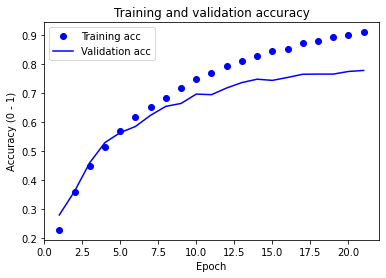

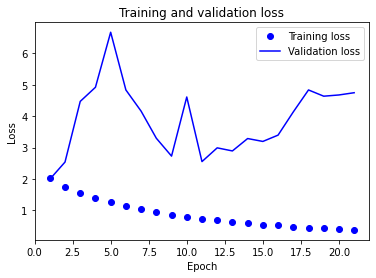

In [27]:
#Save history
with open(NewPath + '/TrainHistoryDict.dict', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)


acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

#Plot 1
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (0 - 1)')
plt.legend()
plt.figure()

#Plot 2
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
